In [138]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import missingno as msno
from scipy.stats import skew, norm
from scipy import stats
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.width = None

For our analysis, we will be looking at detached houses for one, two, and three families in New York City within the past two years since the pandemic, and how their prices are affected by different properties. We choose these properties, as it may give us some insight into how the pandemic has affected people's willingness to start a family.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118044 entries, 0 to 258213
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   BOROUGH                         118044 non-null  int64  
 1   NEIGHBORHOOD                    118044 non-null  object 
 2   BUILDING CLASS CATEGORY         118044 non-null  object 
 3   TAX CLASS AT PRESENT            118043 non-null  object 
 4   BLOCK                           118044 non-null  int64  
 5   LOT                             118044 non-null  int64  
 6   BUILDING CLASS AT PRESENT       118043 non-null  object 
 7   ADDRESS                         118044 non-null  object 
 8   APARTMENT NUMBER                69 non-null      object 
 9   ZIP CODE                        118044 non-null  float64
 10  RESIDENTIAL UNITS               117615 non-null  object 
 11  COMMERCIAL UNITS                117615 non-null  object 
 12  TOTAL UNITS     

<AxesSubplot:>

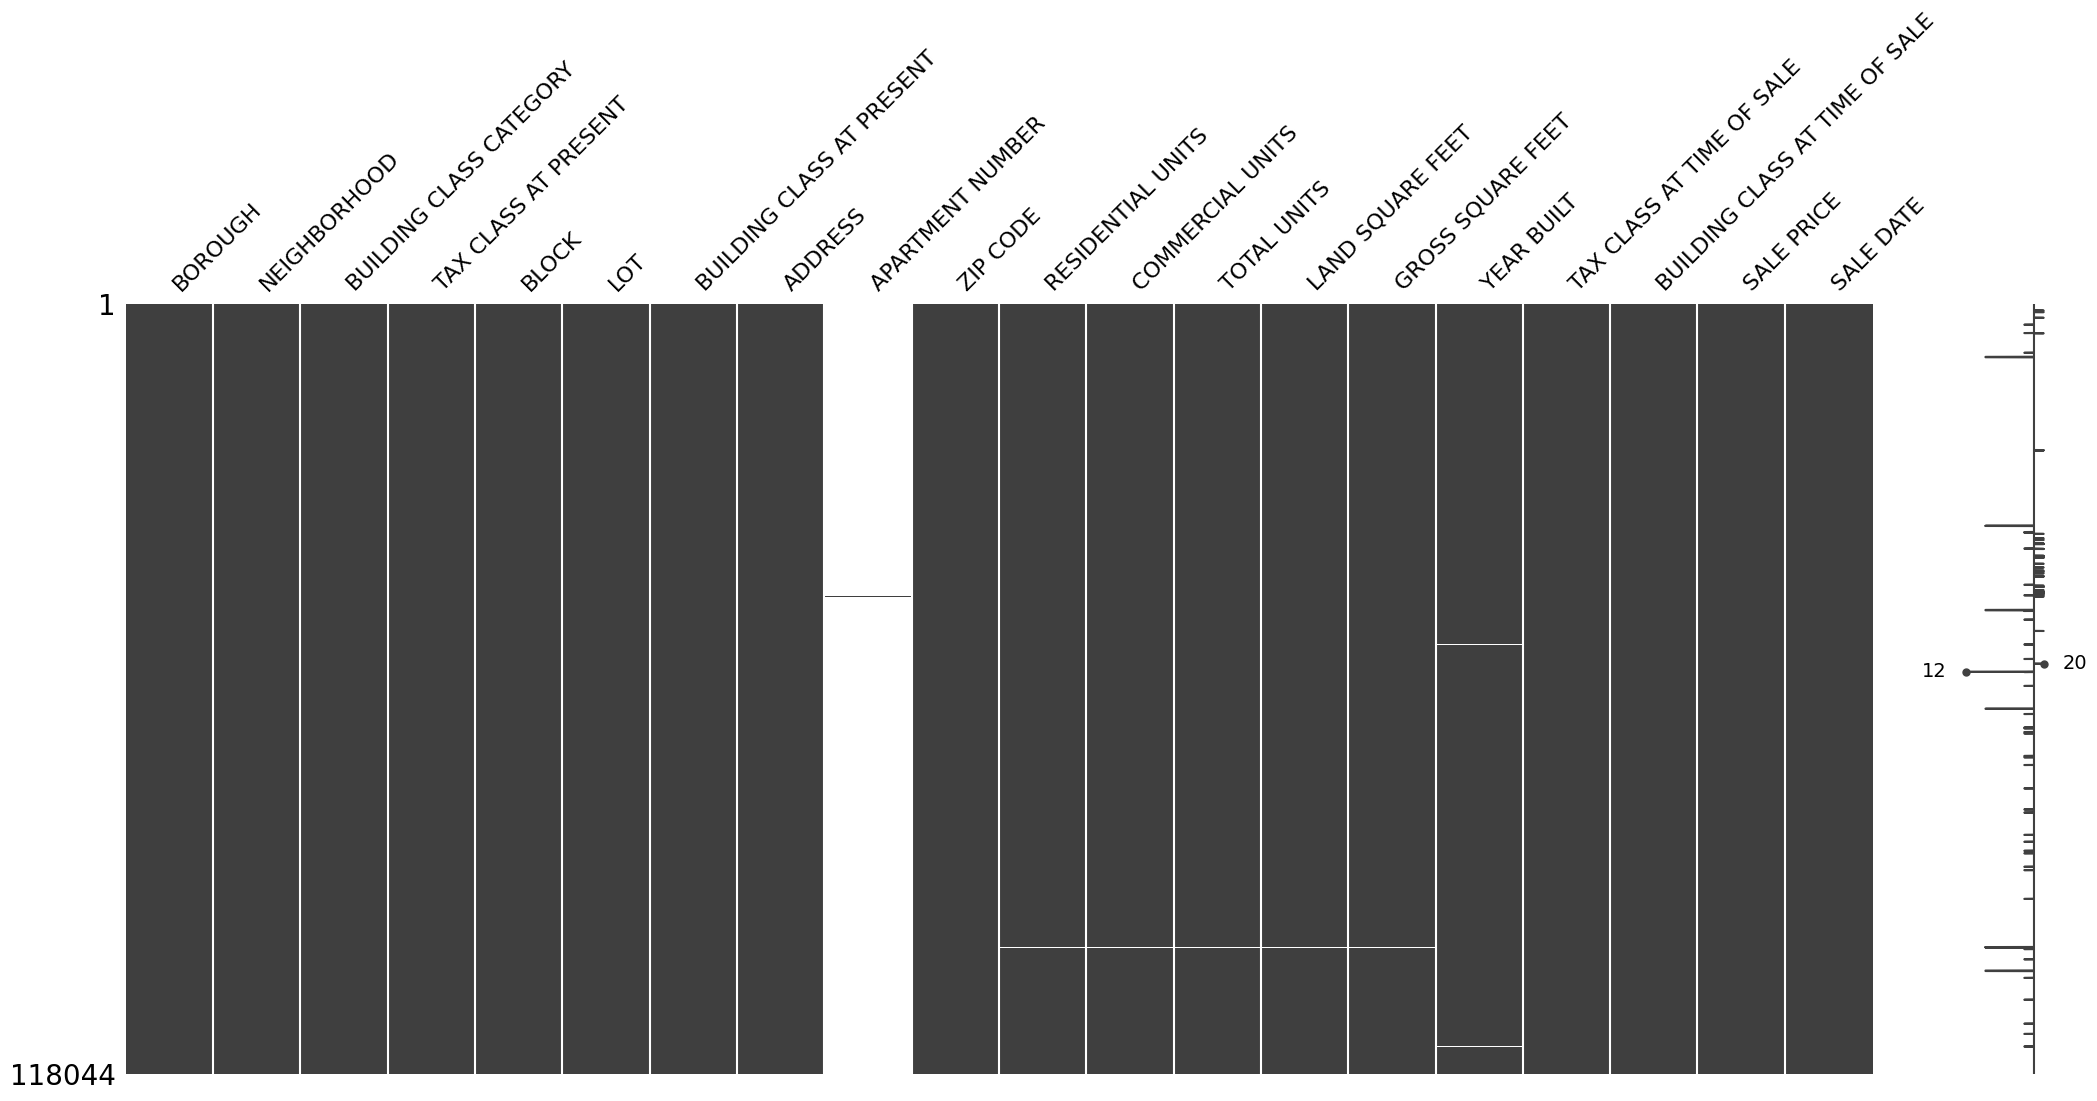

In [139]:
# load data
data = pd.read_csv('20to22NYC.csv')

# filter out all property sales that were not houses meant for families
building_class = ['01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS', '03 THREE FAMILY DWELLINGS']
data = data[data['BUILDING CLASS CATEGORY'].isin(building_class)]

# view info about our data set
data.info()

# visualize missing data as a matrix
msno.matrix(data)

From our filtered data, we observe:
- There are 118,044 entries, and 20 attributes
- Zip code, block, lot, and borough should all be categorical
- Only 69 entries have an apartment number attached to them, so we can easily discard this entire column.
- 389 entries are missing data on the number of residential units, commercial units, total units, and land/gross square footage. Since these are direct measurements taken from a property, imputing a value such as the mean would likely cause problems, so we simply remove them
- There are relatively few entries missing the build year, so we remove them
- There is one entry missing the building class at present, which we also remove

In [140]:
# remove null values from building class
data = data.drop(data[data['BUILDING CLASS AT PRESENT'].isnull()].index)
data = data.drop(data[data['LAND SQUARE FEET'].isnull()].index)

# remove null values for year built
data = data.drop(data[data['YEAR BUILT'].isnull()].index)

# remove apartment number
data = data.drop(['APARTMENT NUMBER'],axis=1)

# fix column types
data['BOROUGH'] = data['BOROUGH'].astype('object')
data['BLOCK'] = data['BLOCK'].astype('category')
data['ZIP CODE'] = data['ZIP CODE'].astype('category')
data['LOT'] = data['LOT'].astype('category')

data['RESIDENTIAL UNITS'] = data['RESIDENTIAL UNITS'].astype('float64')
data['COMMERCIAL UNITS'] = data['COMMERCIAL UNITS'].astype('float64')
data['TOTAL UNITS'] = data['TOTAL UNITS'].astype('float64')

data['TAX CLASS AT TIME OF SALE'] = data['TAX CLASS AT TIME OF SALE'].astype('object')

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117575 entries, 0 to 258213
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   BOROUGH                         117575 non-null  object  
 1   NEIGHBORHOOD                    117575 non-null  object  
 2   BUILDING CLASS CATEGORY         117575 non-null  object  
 3   TAX CLASS AT PRESENT            117575 non-null  object  
 4   BLOCK                           117575 non-null  category
 5   LOT                             117575 non-null  category
 6   BUILDING CLASS AT PRESENT       117575 non-null  object  
 7   ADDRESS                         117575 non-null  object  
 8   ZIP CODE                        117575 non-null  category
 9   RESIDENTIAL UNITS               117575 non-null  float64 
 10  COMMERCIAL UNITS                117575 non-null  float64 
 11  TOTAL UNITS                     117575 non-null  float64 
 12  LA

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,117575.000000,117575.000000,117575.000000,117575.000000,117575.000000,117575.000000,1.175750e+05
mean,1.630091,0.026868,1.656959,3087.236794,2021.309156,1942.438367,5.773705e+05
std,0.701861,0.163321,0.722069,2067.107404,893.941612,30.595253,1.125217e+06
min,0.000000,0.000000,0.000000,165.000000,0.000000,1018.000000,0.000000e+00
25%,1.000000,0.000000,1.000000,2000.000000,1368.000000,1920.000000,0.000000e+00
50%,2.000000,0.000000,2.000000,2500.000000,1848.000000,1935.000000,5.000000e+05
75%,2.000000,0.000000,2.000000,3938.000000,2462.000000,1960.000000,8.400000e+05
max,45.000000,2.000000,45.000000,116130.000000,23295.000000,2022.000000,8.740000e+07


We are then left with 117,575 entries and 19 attributes. In the description of our new data, however, we notice an obvious outlier - a house that was supposedly built in 1018, which is obviously an error in imputation. For consistency, and to catch any other obvious imputation errors, we will filter out all entries with years before 1800, which leaves us with 117,563 entries. We also notice that there are entries with 0 gross square feet, which is likely also an error, as the gross square footage is the total area of the house, and a house cannot have a size of 0. As such, we filter outliers in a similar way - filtering any with a gross square footage less than 10, leaving us with 117,469 entries.

In [141]:
# filter outlier years
data = data[data['YEAR BUILT'] > 1800]
data = data[data['GROSS SQUARE FEET'] > 10]
data.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,117469.000000,117469.000000,117469.000000,117469.000000,117469.000000,117469.000000,1.174690e+05
mean,1.631264,0.026858,1.658123,3086.219998,2022.803872,1942.468566,5.772127e+05
std,0.700595,0.163242,0.720714,2066.245166,892.368199,30.445694,1.125279e+06
min,0.000000,0.000000,1.000000,165.000000,180.000000,1818.000000,0.000000e+00
25%,1.000000,0.000000,1.000000,2000.000000,1368.000000,1920.000000,0.000000e+00
50%,2.000000,0.000000,2.000000,2500.000000,1848.000000,1935.000000,5.000000e+05
75%,2.000000,0.000000,2.000000,3935.000000,2462.000000,1960.000000,8.400000e+05
max,45.000000,2.000000,45.000000,116130.000000,23295.000000,2022.000000,8.740000e+07


We next turn our attention to the sales price column, and the large number of 0 values. Per the glossary provided on the NYC government's website (https://www.nyc.gov/site/finance/taxes/glossary-property-sales.page), sale prices of 0 indicate that there was a transfer of ownership without cash consideration or payment. Since we are interested in the actual sale prices of houses during the pandemic, we obviously don't want these results skewing the data, so we want to remove all prices below a certain threshold.

In [142]:
# show count of values
dat1 = data.groupby(['SALE PRICE']).count()
dat1.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
SALE PRICE,,,,,,,,,,,,,,,,,,
0.0,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326,46326
1.0,456,456,456,456,456,456,456,456,456,456,456,456,456,456,456,456,456,456
5.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10.0,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832
19.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
20.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
25.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
30.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


From the count table, we can see that 46,326 sales were a transfer of ownership without payment - a large amount in proportion to the number of samples we have. However, we also observe a relatively high number being sold for either 1 dollar or 10 dollars - effectively the same as transferring ownership for free, given the median price of this data, even while heavily skewed by the 0 values, being around $500,000. As a result, we filter rows out according to a minimum price of $100,000 - it seems unlikely that any house would realistically sell below this amount. As a result, we are left with 67,860 data points.

In [143]:
data = data[data['SALE PRICE'] > 100000]

data.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,67860.000000,67860.000000,67860.000000,67860.000000,67860.000000,67860.000000,6.786000e+04
mean,1.553905,0.024462,1.578367,3095.554539,1947.343546,1943.432110,9.987002e+05
std,0.655007,0.155999,0.676788,2047.147386,868.648650,31.083655,1.330888e+06
min,0.000000,0.000000,1.000000,250.000000,180.000000,1822.000000,1.010000e+05
25%,1.000000,0.000000,1.000000,2000.000000,1328.000000,1920.000000,6.000000e+05
50%,1.000000,0.000000,1.000000,2500.000000,1760.000000,1935.000000,7.800000e+05
75%,2.000000,0.000000,2.000000,3990.000000,2360.000000,1960.000000,1.040000e+06
max,20.000000,2.000000,20.000000,83425.000000,18814.000000,2022.000000,8.740000e+07


Next, we ask some questions about the data and perform hypothesis testing to determine their validity. Our first question relates to how the price differs between each borough, given the effects of COVID-19. For example, the average NYC office worker plans to cut office time down by 49% (https://www.bloomberg.com/news/articles/2022-03-31/new-yorkers-plan-to-work-from-home-half-the-time). Given this impact, someone who lives in an area like Manhattan may want to sell their house and move to a borough thats farther away, but cheaper and has other opportunities. We set our null hypothesis that there is no difference in the median price from each borough, with an alternate hypothesis that there is a difference.
Since we have five samples, which are not normally distributed, and not paired, we use the Kruskal-Wallis test at a significance level of 0.05.

5600000.0

660000.0

999000.0

805000.0

628000.0

KruskalResult(statistic=13688.54955495373, pvalue=0.0)

<AxesSubplot:xlabel='BOROUGH', ylabel='SALE PRICE'>

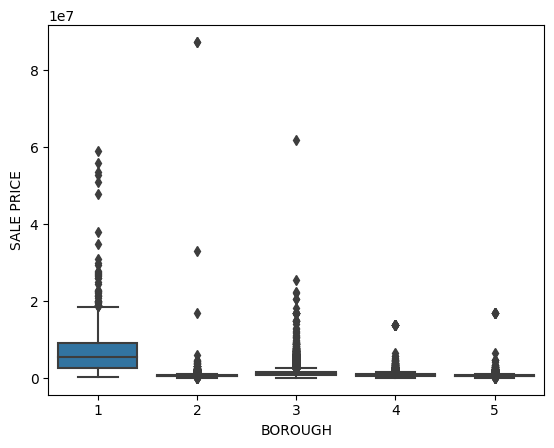

In [144]:
from scipy.stats import kruskal

manhattan = data[data['BOROUGH'] == 1]
bronx = data[data['BOROUGH'] == 2]
brooklyn = data[data['BOROUGH'] == 3]
queens = data[data['BOROUGH'] == 4]
staten = data[data['BOROUGH'] == 5]

manhattan['SALE PRICE'].median()
bronx['SALE PRICE'].median()
brooklyn['SALE PRICE'].median()
queens['SALE PRICE'].median()
staten['SALE PRICE'].median()

kruskal(manhattan['SALE PRICE'], bronx['SALE PRICE'], brooklyn['SALE PRICE'], queens['SALE PRICE'], staten['SALE PRICE'])
sns.boxplot(x='BOROUGH',y='SALE PRICE',data=data)

With a test statistic of 13688.55 and a p-value of 0, we reject the null hypothesis and conclude that there is a difference in the median prices across the boroughs.

For our next hypothesis, we consider the likelihood that house prices have increased since 2020. Over the course of the pandemic, interest rates have increased dramatically, impacting mortgages and other investments/loans. As a result, this may have a noticeable impact on the housing market, such as higher sale prices. Testing again at a significance level of 0.05, we set a null hypothesis of there being no price difference between the years, and an alternative hypothesis that there is a difference.

KruskalResult(statistic=1664.6556798385552, pvalue=0.0)

700000.0

780000.0

845000.0

<AxesSubplot:xlabel='YEAR SOLD', ylabel='SALE PRICE'>

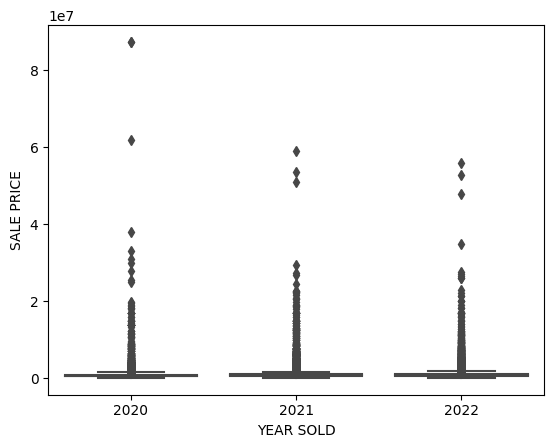

In [145]:
data['SALE DATE'] = pd.to_datetime(data['SALE DATE'], format = '%Y-%m-%d')
data['YEAR SOLD'] = data['SALE DATE'].dt.year # SALE YEAR

data_2020 = data[data['YEAR SOLD'] == 2020]
data_2021 = data[data['YEAR SOLD'] == 2021]
data_2022 = data[data['YEAR SOLD'] == 2022]

kruskal(data_2020['SALE PRICE'], data_2021['SALE PRICE'], data_2022['SALE PRICE'])

data_2020['SALE PRICE'].median()
data_2021['SALE PRICE'].median()
data_2022['SALE PRICE'].median()

sns.boxplot(x='YEAR SOLD',y='SALE PRICE',data=data,palette='rainbow')

For a regression analysis task, we ask the question - what features are associated with an increase in house sale price, and can we use these to accurately predict the sale price of a house?
We begin by analyzing the raw features from our preprocessed data set
- Some boroughs are more desirable than others, so it seems likely that this would have an impact on the house price
- Likewise, some neighbourhoods are more desirable for a variety of reasons, so we select the neighborhood category
- Since we are comparing three different building classes (one family, two family, three family homes), we keep the building class category
- Building class at present and building class at time of sale give us information about each individual property (see here:https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html) - 
whether it's a mansion, summer cottage, suburban residence, etc. We keep this as it tells us information about the specifics of a house that we wouldn't have otherwise.
- The block a house is on could be an important feature, that links it to other similar houses within its vicinity. However, the lot feature is a subset of this that represents the unique location of the property on a block. Since this is contained to one single block, there's likely no reasonable information that can be gained from this, so we don't include it.
- Since all residential properties fall under tax class 1, per the NYC gov glossary, we don't include either tax class at time of sale or tax class at present
- The zip code feature gives us more location data, so we keep it
- In our preprocessed data, we notice that there are a handful of entries that contain commercial entries - perhaps one of the units in a multi family dwelling is someone's office, or a store front, for example. This could potentially impact the price of a property, as well as the number of residential units and total units, so we keep all three features.
- We are given two features relating to square footage - land square footage (the size of the land itself), and gross square footage (the total size of all floors of the building on the land). Since there's inherently a great deal of variance between these - some houses are small and built on a large plot of land, and some are tall and built on smaller plots of land, we keep both features, and create an additional feature named AVERAGE SQUARE FEET - the average of the two measurements for each property.
- The year a house was built seems like it may be useful - older houses tend to be desirable for many reasons, so we use this feature.
- Although the sale date in its raw form isn't useful, we can extract potentially useful features from this, such as the year of sale and the month of sale. We can also leverage this alongside the YEAR BUILT feature, in order to create an AGE AT SALE feature.

In [146]:

# convert to datetime in order to split into separate features
data['SALE DATE'] = pd.to_datetime(data['SALE DATE'], format = '%Y-%m-%d')

data['YEAR SOLD'] = data['SALE DATE'].dt.year
data['MONTH SOLD'] = data['SALE DATE'].dt.month
data['AGE AT SALE'] = data['YEAR SOLD'] - data['YEAR BUILT']

data['AVERAGE SQUARE FEET'] = (data['LAND SQUARE FEET'] + data['GROSS SQUARE FEET']) / 2
data.describe()


,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,YEAR SOLD,MONTH SOLD,AGE AT SALE,AVERAGE SQUARE FEET
count,67860.000000,67860.000000,67860.000000,67860.000000,67860.000000,67860.000000,6.786000e+04,67860.00000,67860.000000,67860.000000,67860.000000
mean,1.553905,0.024462,1.578367,3095.554539,1947.343546,1943.432110,9.987002e+05,2021.07041,6.536826,77.638299,2521.449042
std,0.655007,0.155999,0.676788,2047.147386,868.648650,31.083655,1.330888e+06,0.78019,3.487714,31.110617,1186.707092
min,0.000000,0.000000,1.000000,250.000000,180.000000,1822.000000,1.010000e+05,2020.00000,1.000000,-1.000000,397.000000
25%,1.000000,0.000000,1.000000,2000.000000,1328.000000,1920.000000,6.000000e+05,2020.00000,3.000000,61.000000,1859.500000
50%,1.000000,0.000000,1.000000,2500.000000,1760.000000,1935.000000,7.800000e+05,2021.00000,7.000000,86.000000,2301.000000
75%,2.000000,0.000000,2.000000,3990.000000,2360.000000,1960.000000,1.040000e+06,2022.00000,10.000000,100.000000,2880.000000
max,20.000000,2.000000,20.000000,83425.000000,18814.000000,2022.000000,8.740000e+07,2022.00000,12.000000,200.000000,50262.500000


Next, we take a look at the distribution of sale prices to see if they are skewed, and what transformations we can apply to mitigate this

In [147]:
px.histogram(data, x = 'SALE PRICE')

c:\Users\callu\OneDrive\Documents\CISC 351\CISC\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



SALE PRICE             21.500849
LAND SQUARE FEET        7.590798
AVERAGE SQUARE FEET     6.546681
COMMERCIAL UNITS        6.342264
GROSS SQUARE FEET       2.267822
RESIDENTIAL UNITS       1.159920
TOTAL UNITS             1.108906
dtype: float64

c:\Users\callu\OneDrive\Documents\CISC 351\CISC\lib\site-packages\ipykernel_launcher.py:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




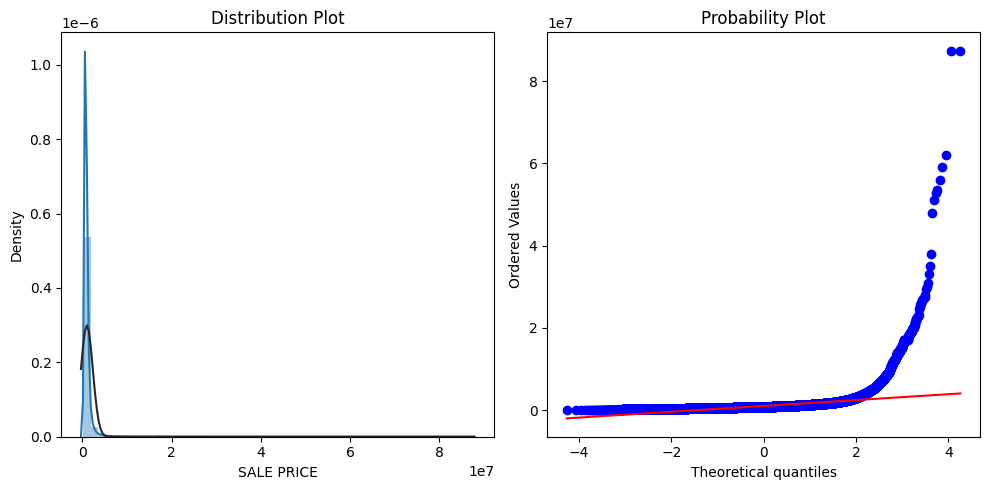

In [148]:
skewness = data.skew().sort_values(ascending=False)
skewness[abs(skewness) > 1]

def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()

normality_plot(data['SALE PRICE'])

From this, we see that the sales prices are very heavily skewed to the right - with a skew value of 21.500. To try and remedy this, we apply a log scale transformation

c:\Users\callu\OneDrive\Documents\CISC 351\CISC\lib\site-packages\ipykernel_launcher.py:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




0.8965505965770962

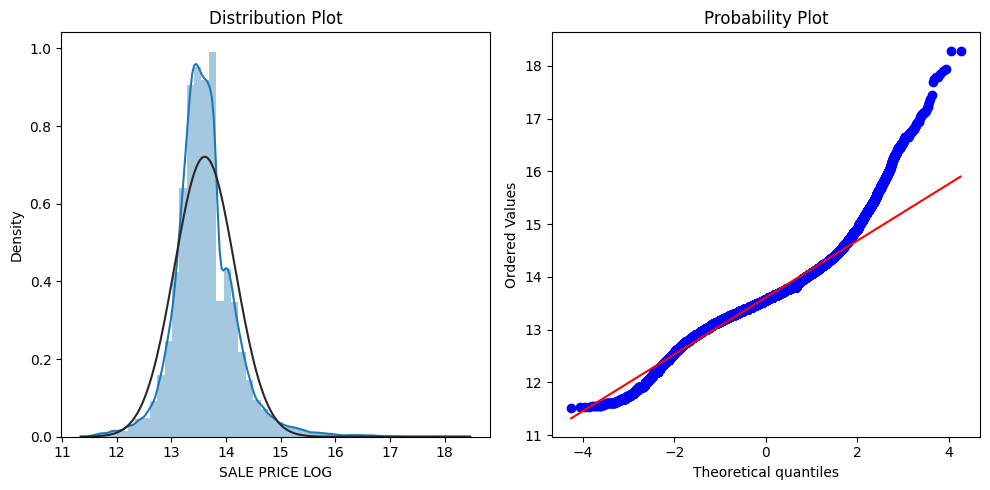

In [149]:
data['SALE PRICE LOG'] = np.log(data['SALE PRICE'])
normality_plot(data['SALE PRICE LOG'])
skewness = data['SALE PRICE LOG'].skew()
skewness

Although still moderately skewed to the right, we obtain a skew value of 0.89 - a noticeable improvement. We add the transformed sales prices as a feature named 'SALES PRICE LOG'

Next, we check the multicolinearity of our data, using the Pearson correlation test

<AxesSubplot:>

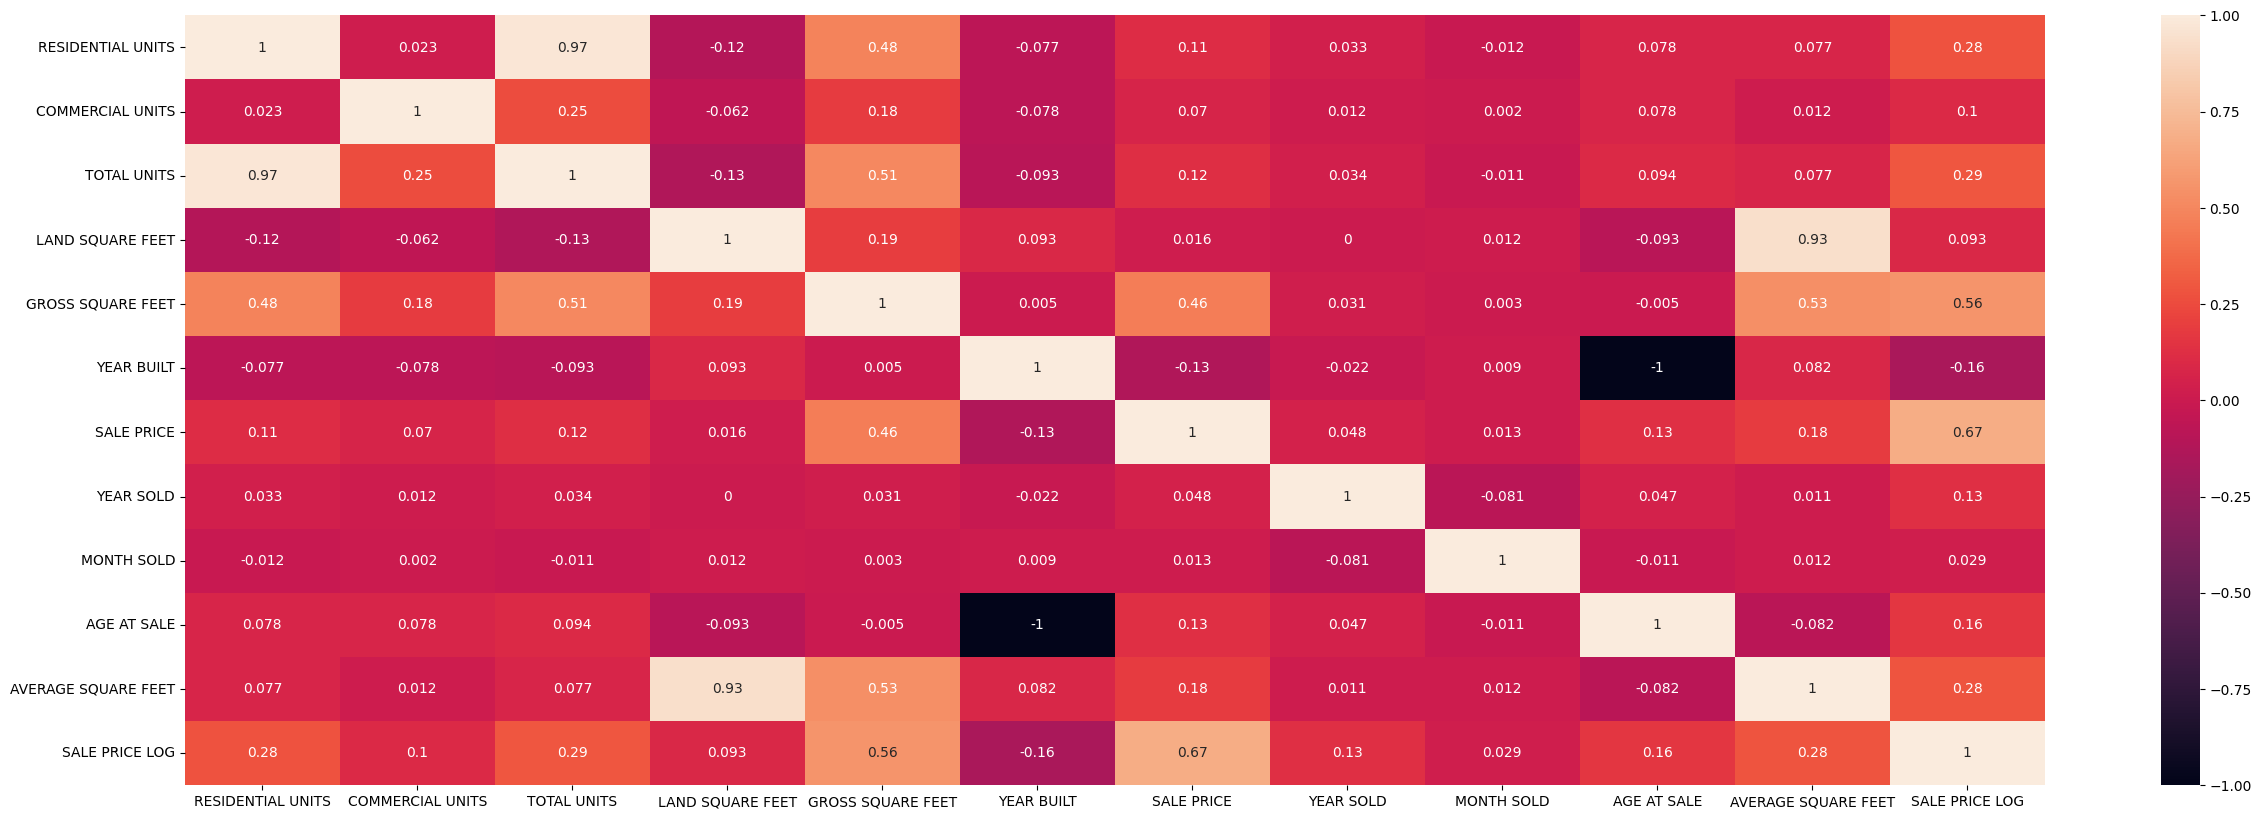

In [150]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(data.corr(method = "pearson").round(3), ax=ax, annot=True)

Looking at the Pearson correlation matrix, we see most of the extremely high correlation values are from features derived from other ones - for example, the -1 correlation between YEAR BUILT and AGE OF BUILDING, and the 0.97 correlation between TOTAL UNITS and RESIDENTIAL UNITS, as well as the 0.93 correlation between LAND SQUARE FEET and AVERAGE SQUARE FEET. As a result, we remove YEAR BUILT, TOTAL UNITS,and LAND SQUARE FEET before our regression analysis. We also note that there's a strong, but not overwhelming correlation between sales price and gross square footage, which may be of interest - does house size reflect the sale price more than the size of the land it's on?

Now, we build our first model. Before analysis, we apply a log-scale transform to the skewed columns still in the data set, as found during the feature analysis stage - AVERAGE SQUARE FEET, COMMERCIAL UNITS, GROSS SQUARE FEET, and RESIDENTIAL UNITS. We also apply feature scaling and create dummy variables out of our categorical attributes. We then train our model according to both the unmodified sale prices, and the log scale transformed sale prices, and assess by three different measures - the RMSE of the unmodified sale prices, the log scale RMSE of the sale prices, and the RMSE of the log scale prediction after being transformed back to the original scale

Our first baseline model is a simple ridge regression, with alpha = 1.

In [151]:
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

# attributes of data
attributes = ['BOROUGH', 'NEIGHBORHOOD', 'BLOCK','BUILDING CLASS AT PRESENT', 'ZIP CODE', 'RESIDENTIAL UNITS', 
                       'COMMERCIAL UNITS', 'GROSS SQUARE FEET', 'BUILDING CLASS AT TIME OF SALE', 'YEAR SOLD',
                       'MONTH SOLD', 'AGE AT SALE', 'AVERAGE SQUARE FEET', 'SALE PRICE', 'SALE PRICE LOG']

# create data set out of attributes
selected_data = data[attributes]

# train test split
train, test = train_test_split(selected_data, test_size=0.2, shuffle=True, random_state=123)
y_train = train['SALE PRICE']
y_test = test['SALE PRICE']
y_trainlog = train['SALE PRICE LOG']
y_testlog = test['SALE PRICE LOG']
X_train = train.drop(['SALE PRICE','SALE PRICE LOG'], axis=1)
X_test  = test.drop(['SALE PRICE','SALE PRICE LOG'], axis=1)

# log scale transform skewed columns
def log_transfer(X_train, X_test):
    skewness = X_train.skew().sort_values(ascending=False)
    skewed_cols = list(skewness[abs(skewness) > 1].index)
    for col in skewed_cols:
        X_train[col] = np.log(1 + X_train[col])
        X_test[col] = np.log(1 + X_test[col])


def feature_scaling(X_train, X_test):
    scaler = RobustScaler()
    num_cols = list(X_train.select_dtypes(exclude=['object']).columns)
    scaler.fit(X_train[num_cols])
    X_train[num_cols] = scaler.transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

log_transfer(X_train, X_test)
feature_scaling(X_train, X_test)

train_objs_num = len(X_train)
data = pd.concat(objs=[X_train, X_test], axis=0)
data = pd.get_dummies(data,  drop_first=True)
X_train = data[:train_objs_num]
X_test = data[train_objs_num:]

print("final data shape", data.shape)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def train_test(model):
    print(model)
    
    model.fit(X_train, y_train)
    print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
    print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))
    px.scatter(x = y_test, y = model.predict(X_test))
    
    model.fit(X_train, y_trainlog)
    print("RMSE train log-scale: {}".format(rmse(y_trainlog, model.predict(X_train))))
    print("RMSE test log-scale: {}".format(rmse(y_testlog,  model.predict(X_test))))
    px.scatter(x = y_testlog, y = model.predict(X_test))
    
    # get true predictions by transforming from log scale back to normal scale
    print("RMSE train log-scale (converted): {}".format(rmse(np.exp(y_trainlog), np.exp(model.predict(X_train)))))
    print("RMSE test log-scale (converted): {}".format(rmse(np.exp(y_testlog), np.exp(model.predict(X_test)))))
    px.scatter(x = y_test, y = np.exp(model.predict(X_test)))

model_base = Ridge(alpha = 1)
train_test(model_base) 

c:\Users\callu\OneDrive\Documents\CISC 351\CISC\lib\site-packages\ipykernel_launcher.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



final data shape (67860, 290)
Ridge(alpha=1)
RMSE train: 985037.6200694846
RMSE test : 693106.1192197064
RMSE train log-scale: 0.32006213397820094
RMSE test log-scale: 0.31637701225238
RMSE train log-scale (converted): 949721.0337681738
RMSE test log-scale (converted): 626073.7346474549


Looking at our results, we get a test RMSE of around 690,000 for the model trained on the unmodified sale prices, a log scale test RMSE of around 0.316, and a test RMSE of around 625,000 on the log scale predictions converted back to normal. From this, we conclude that the log scaling of the sale prices significantly improved our predictions.

For our improved model, we're choosing a different type of regression model - a random forest set to iterate 100 times

In [152]:
model_rf = RandomForestRegressor(n_estimators=100)
train_test(model_rf)

RandomForestRegressor()
RMSE train: 287188.7132975309
RMSE test : 634531.0918090377
RMSE train log-scale: 0.12037444619777644
RMSE test log-scale: 0.3155002207685022
RMSE train log-scale (converted): 393865.0687556634
RMSE test log-scale (converted): 543913.5352459033


For our random forest, we get an unmodified test RMSE of around 600,000, a log scale test RMSE around 0.315, and a test rmse of around 550,000 on the log scale predictions after converting back to normal. This is a solid improvement on our ridge regression baseline, improving by several tens of thousands of dollars in both applicable cases